# Model selection

In this notebook I will elaborate on the hypotezis that it is enough to train a simple NN or linear classifier to predict rankings of films. I will try to select an appropriate model and then fine-tune it.

In [1]:
import pandas as pd
import sys
import os
sys.path.append("../")
from definitions import ROOT_DIR
import numpy as np

## Data splitting

In [15]:
data_folder = os.path.join(ROOT_DIR, 'data/interim')
figures_folder = os.path.join(ROOT_DIR, 'reports/figures')

In [3]:
data = pd.read_csv(os.path.join(data_folder, 'all.csv'))

In [4]:
data.head(2)

,rating,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Washington,West Virginia,Wisconsin,Wyoming,0-18,18-27,27-35,35-42,42-55,55+
0,3,0.534335,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,3,0.534335,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
y = data['rating'].to_numpy()
X = data.drop('rating', axis=1, errors='ignore').to_numpy()
X.shape, y.shape

((100000, 103), (100000,))

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear classifier

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [16]:
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)
print("Train RMSE:", mean_squared_error(y_train, model.predict(X_train), squared=False))
print("Test RMSE:", mean_squared_error(y_test, model.predict(X_test), squared=False))

Train RMSE: 1.0752317794463297
Test RMSE: 1.0770118583133976


## Neural network

In [8]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch import optim

In [9]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train) - 1
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test) - 1

In [10]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size * 2)
        self.fc3 = nn.Linear(hidden_size * 2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [12]:
input_size = 103
hidden_size = 256
output_size = 1
model = NeuralNet(input_size, hidden_size, output_size)

In [13]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

train_losses = []
test_losses = []

In [14]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).view(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    model.eval()
    test_running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            outputs = model(inputs).view(-1)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()

    train_loss = running_loss/len(train_loader)
    test_loss = test_running_loss/len(test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{num_epochs}\t train loss: {train_loss}\t test loss: {test_loss}")

Epoch 1/50	 train loss: 1.2379557599067688	 test loss: 1.1602476689338683
Epoch 2/50	 train loss: 1.168810084450245	 test loss: 1.1440455794334412
Epoch 3/50	 train loss: 1.1445805692076683	 test loss: 1.140311210823059
Epoch 4/50	 train loss: 1.1260150890946388	 test loss: 1.1107820326805116
Epoch 5/50	 train loss: 1.11353038803339	 test loss: 1.1208960433006288
Epoch 6/50	 train loss: 1.100038271999359	 test loss: 1.0989303168296813
Epoch 7/50	 train loss: 1.0899991375923157	 test loss: 1.0930332155227662
Epoch 8/50	 train loss: 1.0848219673633575	 test loss: 1.0962074702262878
Epoch 9/50	 train loss: 1.0756538738012313	 test loss: 1.1010095372200013
Epoch 10/50	 train loss: 1.0736696387529374	 test loss: 1.0822801809310914
Epoch 11/50	 train loss: 1.066584426677227	 test loss: 1.0775440304279327
Epoch 12/50	 train loss: 1.059016715979576	 test loss: 1.0828353262901307
Epoch 13/50	 train loss: 1.054636268377304	 test loss: 1.106488961982727
Epoch 14/50	 train loss: 1.0467483553528785

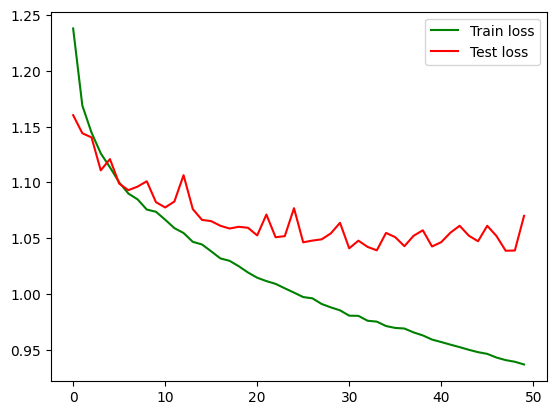

In [16]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train loss', color='green')
plt.plot(test_losses, label='Test loss', color='red')
plt.legend()
plt.savefig(os.path.join(figures_folder, 'v1_nn_training.png'))
plt.show()

In [28]:
# Evaluation on the test set
model.eval()
correct = 0
total = 0

all_labels = torch.Tensor(0)
all_outputs = torch.Tensor(0)
all_outputs_rounded = torch.Tensor(0)

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs).view(-1)
        rounded = torch.round(outputs)
        total += labels.size(0)
        correct += (rounded == labels).sum().item()

        all_labels = torch.cat((all_labels, labels))
        all_outputs = torch.cat((all_outputs, outputs))
        all_outputs_rounded = torch.cat((all_outputs_rounded, rounded))

accuracy = correct / total
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.3785


RMSE loss:

In [27]:
mean_squared_error(all_labels.numpy(), all_outputs.numpy(), squared=False)

1.0344238

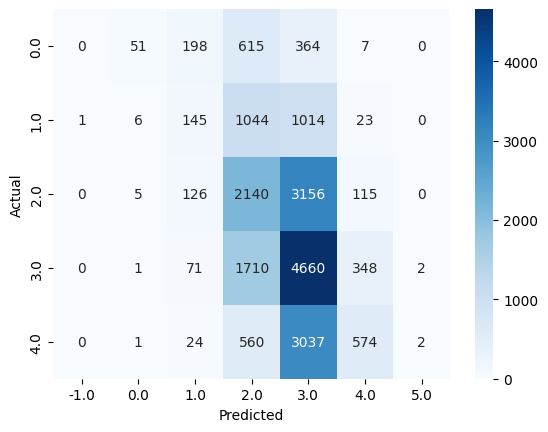

In [29]:
import seaborn as sns

confusion_matrix = pd.crosstab(all_labels, all_outputs_rounded, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.savefig(os.path.join(figures_folder, 'v1_nn_confusion_mtr.png'))
plt.show()

## Analyzing results

As we can see, this straightforward approach does not perform well (I have tried many NN architectures, regularizations, etc). We can clearly see that model can find train-specific patterns, but this patterns are not common, so the model just overfits. I believe this is because these models do not analyze data about a certain user or film, while it is essential to analyze each particular user info and ratings separately.

**Now I will try a different approach** to solve this task. I will engineer data again in '3.1-data-engineering.ipynb', train another model in '4.1-model-selection' and etc.